In [536]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [537]:
import numpy as np
import pandas as pd

In [538]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [539]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect,and_,distinct,desc


In [540]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")





In [541]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [542]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [543]:
#view the class measurement
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()



[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [544]:
#view the class station
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [545]:
#view the columns in the table measurement
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [546]:
#view the columns in the table station
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [547]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [548]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

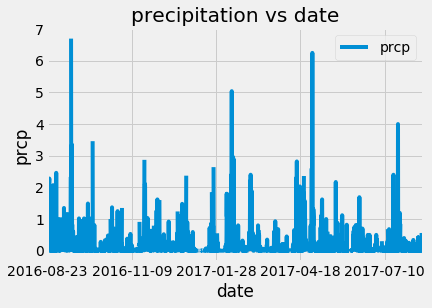

In [549]:
# Design a query to retrieve the last 12 months of precipitation data and plot the result
#calculate the latest date
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#extract the string from object
date_1 = recent_date[0]
#Bring the date to date format
date_2 = dt.datetime.strptime(date_1,"%Y-%m-%d")
date_2
# Calculate the date 1 year ago from the last data point in the database
year_ago =date_2 - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
qry_prcp = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >=year_ago.date()).all()
#print(qry)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(qry_prcp[0:],columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True, )
prcp_df.head
# Sort the dataframe by date
prcp_df = df.sort_values('date',ascending=True)
prcp_df.head(5)
#df.dtypes
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.line()
plt.title("precipitation vs date")
plt.xlabel("date")
plt.ylabel("prcp");
plt.show()

In [550]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [551]:
# Design a query to show how many stations are available in this dataset?
xy = session.query(func.count(distinct(Station.name))).scalar()
print(xy)



9


In [552]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations= session.query(Measurement.station,func.count(Measurement.id).label('inst_count')).\
group_by(Measurement.station).\
order_by(desc('inst_count')).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [553]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
Most_active_station = session.query(Measurement.station,func.count(Measurement.id).label('inst_count')).\
group_by(Measurement.station).order_by(desc('inst_count')).first()
print ( "The top active station in the table is " + str(Most_active_station))
#calculate min,max and average for most active station
active_station_func=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station==Most_active_station[0]).all()
print(active_station_func)


The top active station in the table is ('USC00519281', 2772)
[(54.0, 85.0, 71.66378066378067)]


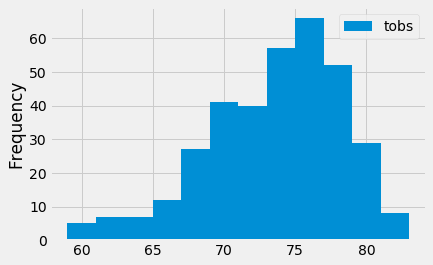

In [554]:
# Choose the station with the highest number of temperature observations and Query the last 12 months of temperature observation data for this station  
highest_temp = session.query(Measurement.tobs,Measurement.date).\
filter(Measurement.station==Most_active_station[0]).\
filter(Measurement.date>year_ago.date()).order_by(Measurement.date).all()
highest_temp


#put the result in a dataframe
df_temp = pd.DataFrame(highest_temp[0:],columns=['tobs','date'])
df_temp
df_temp2 = df2[['tobs']]
df_temp2

# plot the results as a histogram
df_temp2.plot.hist(bins=12)




In [555]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [523]:
#Decide start and end date of trip
my_trip_start_date = '2017-07-27'
my_trip_end_date = '2017-08-05'
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_temp = calc_temps(my_trip_start_date, my_trip_end_date)
print(my_trip_temp)

[(72.0, 78.96078431372548, 84.0)]


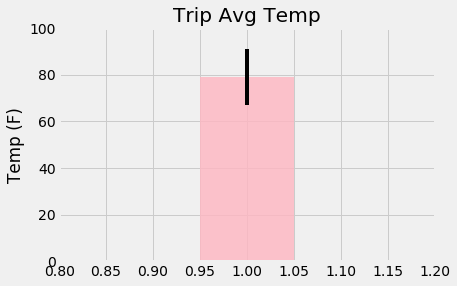

In [556]:
# Plot the results from your previous query as a bar chart. 
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#meantemp = df[my_trip_temp[0][1]]
#stdsum = df["error"]
# Use the average temperature for the y value
plt.bar(1,my_trip_temp[0][1],yerr=my_trip_temp[0][2]-my_trip_temp[0][0],color = 'Lightpink', alpha = .8,width=0.1)
# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.ylim(0, 100)
plt.xlim(0.8, 1.2)
plt.show()

In [557]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_trip = session.query(Station.station,Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('prcp_sum')).\
group_by(Measurement.station).filter(Measurement.station == Station.station).filter(Measurement.date >= my_trip_start_date).filter(Measurement.date <= my_trip_end_date).\
order_by(desc('prcp_sum')).all()
prcp_trip







[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.31),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.39),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.38),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.19),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.01),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

## Optional Challenge Assignment

In [558]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [559]:
# calculate the daily normals for your trip
# Set the start and end date of the trip
my_trip_start_date = '2019-07-27'
my_trip_end_date = '2019-08-05'

# Use the start and end date to create a range of dates
a = dt.datetime.strptime(my_trip_start_date, "%Y-%m-%d")
b = dt.datetime.strptime(my_trip_end_date, "%Y-%m-%d")
tripdays = (b - a).days
dateslist = []
dateslist_norm_min = []
dateslist_norm_avg = []
dateslist_norm_max = []
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
for x in range (0, tripdays):
    dateslist.append((a + dt.timedelta(days = x)).strftime("%Y-%m-%d"))
    dateslist_norm_min.append(daily_normals((a + dt.timedelta(days = x)).strftime("%m-%d"))[0][0])
    dateslist_norm_avg.append(daily_normals((a + dt.timedelta(days = x)).strftime("%m-%d"))[0][1])
    dateslist_norm_max.append(daily_normals((a + dt.timedelta(days = x)).strftime("%m-%d"))[0][2])
#put the result in a dataframe
trip_dates_merged=pd.DataFrame({'date':dateslist,'tmin':dateslist_norm_min,'tavg':dateslist_norm_avg,'tmax':dateslist_norm_max})
trip_dates_merged['date'] = trip_dates_merged['date'].astype(str)
trip_dates_merged

,date,tmin,tavg,tmax
0,2019-07-27,68.0,76.581818,83.0
1,2019-07-28,69.0,76.464286,82.0
2,2019-07-29,69.0,76.470588,83.0
3,2019-07-30,69.0,77.351852,84.0
4,2019-07-31,72.0,77.035714,83.0
5,2019-08-01,67.0,75.540000,83.0
6,2019-08-02,68.0,75.603774,84.0
7,2019-08-03,70.0,76.611111,85.0
8,2019-08-04,69.0,76.711538,84.0


In [560]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates_merged.set_index('date', inplace=True, )
trip_dates_merged

,tmin,tavg,tmax
date,,,
2019-07-27,68.0,76.581818,83.0
2019-07-28,69.0,76.464286,82.0
2019-07-29,69.0,76.470588,83.0
2019-07-30,69.0,77.351852,84.0
2019-07-31,72.0,77.035714,83.0
2019-08-01,67.0,75.540000,83.0
2019-08-02,68.0,75.603774,84.0
2019-08-03,70.0,76.611111,85.0
2019-08-04,69.0,76.711538,84.0


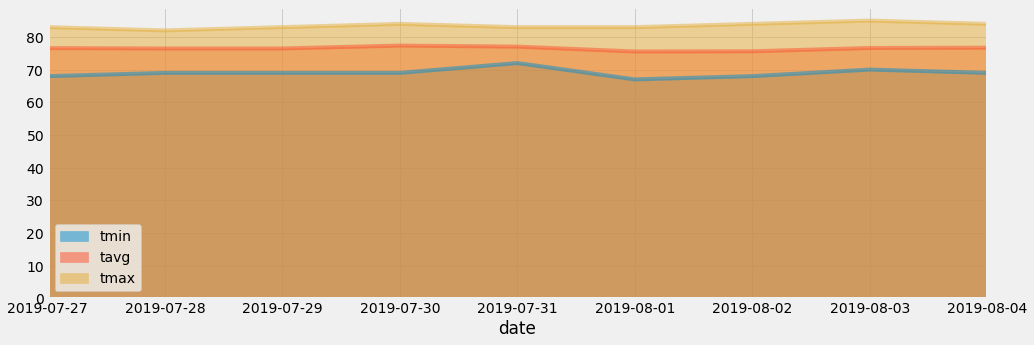

In [561]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates_merged.plot.area(stacked = False,figsize=(15,5))